# 1. Set up the notebook
Import modules.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define the rotation matrix $R_1^0$ as a function of the yaw angle $\psi$, the pitch angle $\theta$, and the roll angle $\phi$.

In [3]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_1in0 that describes the orientation of the drone
# (i.e., of frame 1 in the coordinates of frame 0)
R_1in0 = Rz @ Ry @ Rx

# Create a function that returns R_1in0 as a numpy array
R_1in0 = sym.lambdify((psi, theta, phi), R_1in0)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

Define a function to compute RMSE.

In [4]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

Define a function to compare custom observer and default observer

In [6]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (custom observer)', linewidth=2)
    ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

# 2. Get Data

In [7]:
# flight test data
data = load_hardware_data('NOOR_flight_5.json', only_in_flight=False)

In [8]:
# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], phi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]


## Define Constant

In [9]:
# Define constants
g = 9.81
k_flow = 4.09255568
o_z_eq = 0.5 # <-- FIXME: change equilibrium height
dt = 0.01

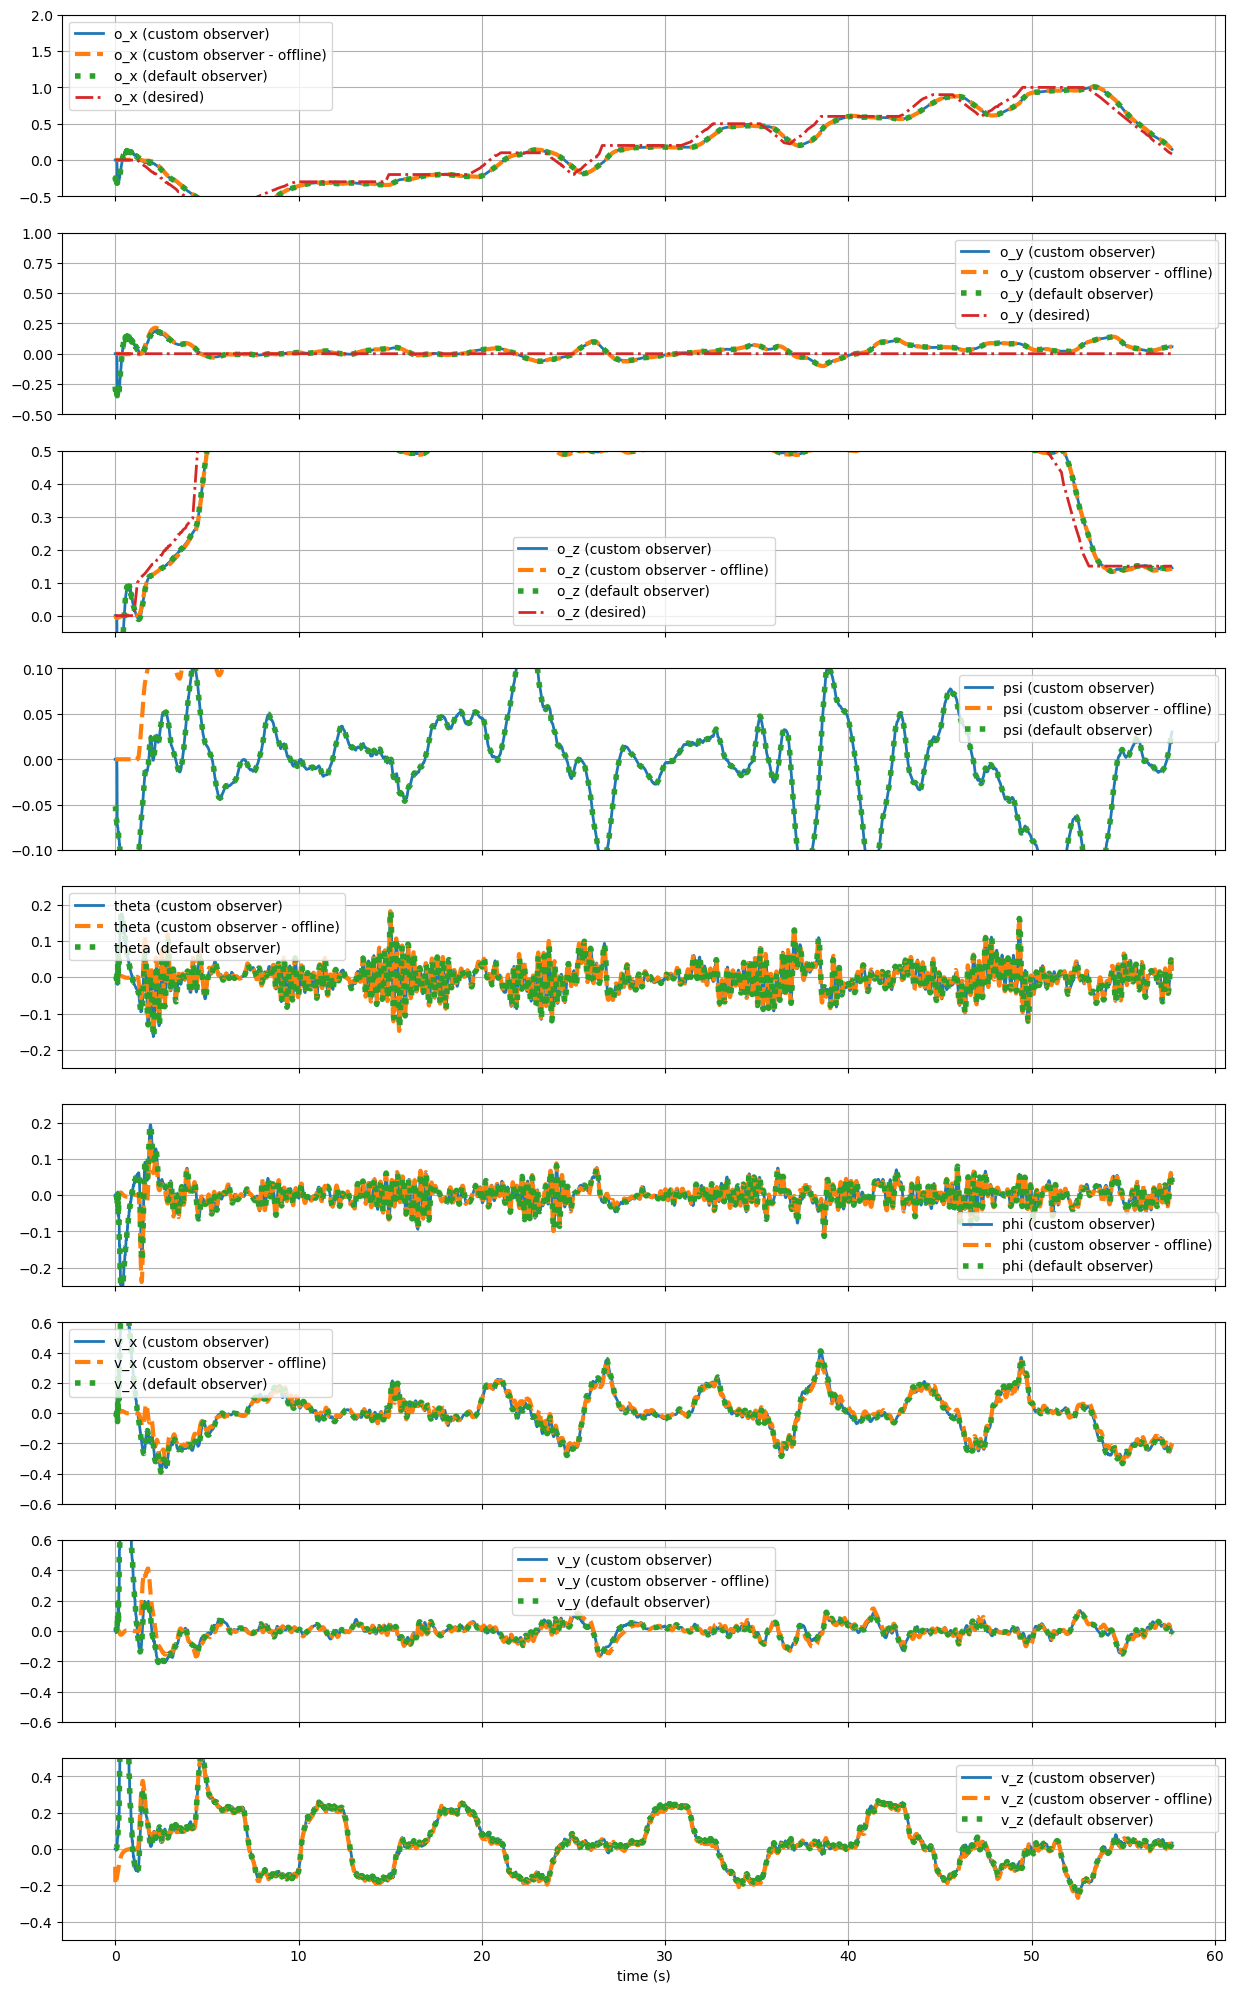

In [10]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (custom observer)', linewidth=2)
    ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], phi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

# Define constants
g = 9.81
# k_flow = 4.09255568
o_z_eq = 0.5 # <-- FIXME: change equilibrium height
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
lh_x_offline = data['ae483log.lh_x']
lh_y_offline = data['ae483log.lh_y']
lh_z_offline = data['ae483log.lh_z']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    lh_x = lh_x_offline[i]
    lh_y = lh_y_offline[i]
    lh_z = lh_z_offline[i]
    
    # Compute each element of: C x + D u - y
    lh_x_err = o_x - lh_x  # <-- FIXME
    lh_y_err = o_y - lh_y  # <-- FIXME
    lh_z_err = o_z - lh_z    # <-- FIXME
    
    # Update estimates
    o_x += dt * (-17.7581819124871*lh_x_err + 1.0*v_x)   # <-- FIXED
    o_y += dt * (-17.7223121570295*lh_y_err + 1.0*v_y)   # <-- FIXED
    o_z += dt * (-21.4301189917369*lh_z_err + 1.0*v_z)   # <-- FIXED
    psi += dt * (w_z)   # <-- FIXED
    theta += dt * (-34.3333333333332*lh_x_err + w_y) # <-- FIXED
    phi += dt * (50.7499999999999*lh_y_err + w_x)   # <-- FIXED
    v_x += dt * (-120.120956862936*lh_x_err + 9.81*theta)   # <-- FIXED
    v_y += dt * (-135.915174095598*lh_y_err - 9.81*phi)   # <-- FIXED
    v_z += dt * (a_z - g - 93.5000000000001*lh_z_err)   # <-- FIXED
    
    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z


fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-0.5, 2])
ax_o_y.set_ylim([-0.5, 1])
ax_o_z.set_ylim([-0.05, 0.5])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.25, 0.25])
ax_phi.set_ylim([-0.25, 0.25])
ax_v_x.set_ylim([-0.6, 0.6])
ax_v_y.set_ylim([-0.6, 0.6])
ax_v_z.set_ylim([-0.5, 0.5])

plt.show()

# 3. Analysis

## Comparison Plot

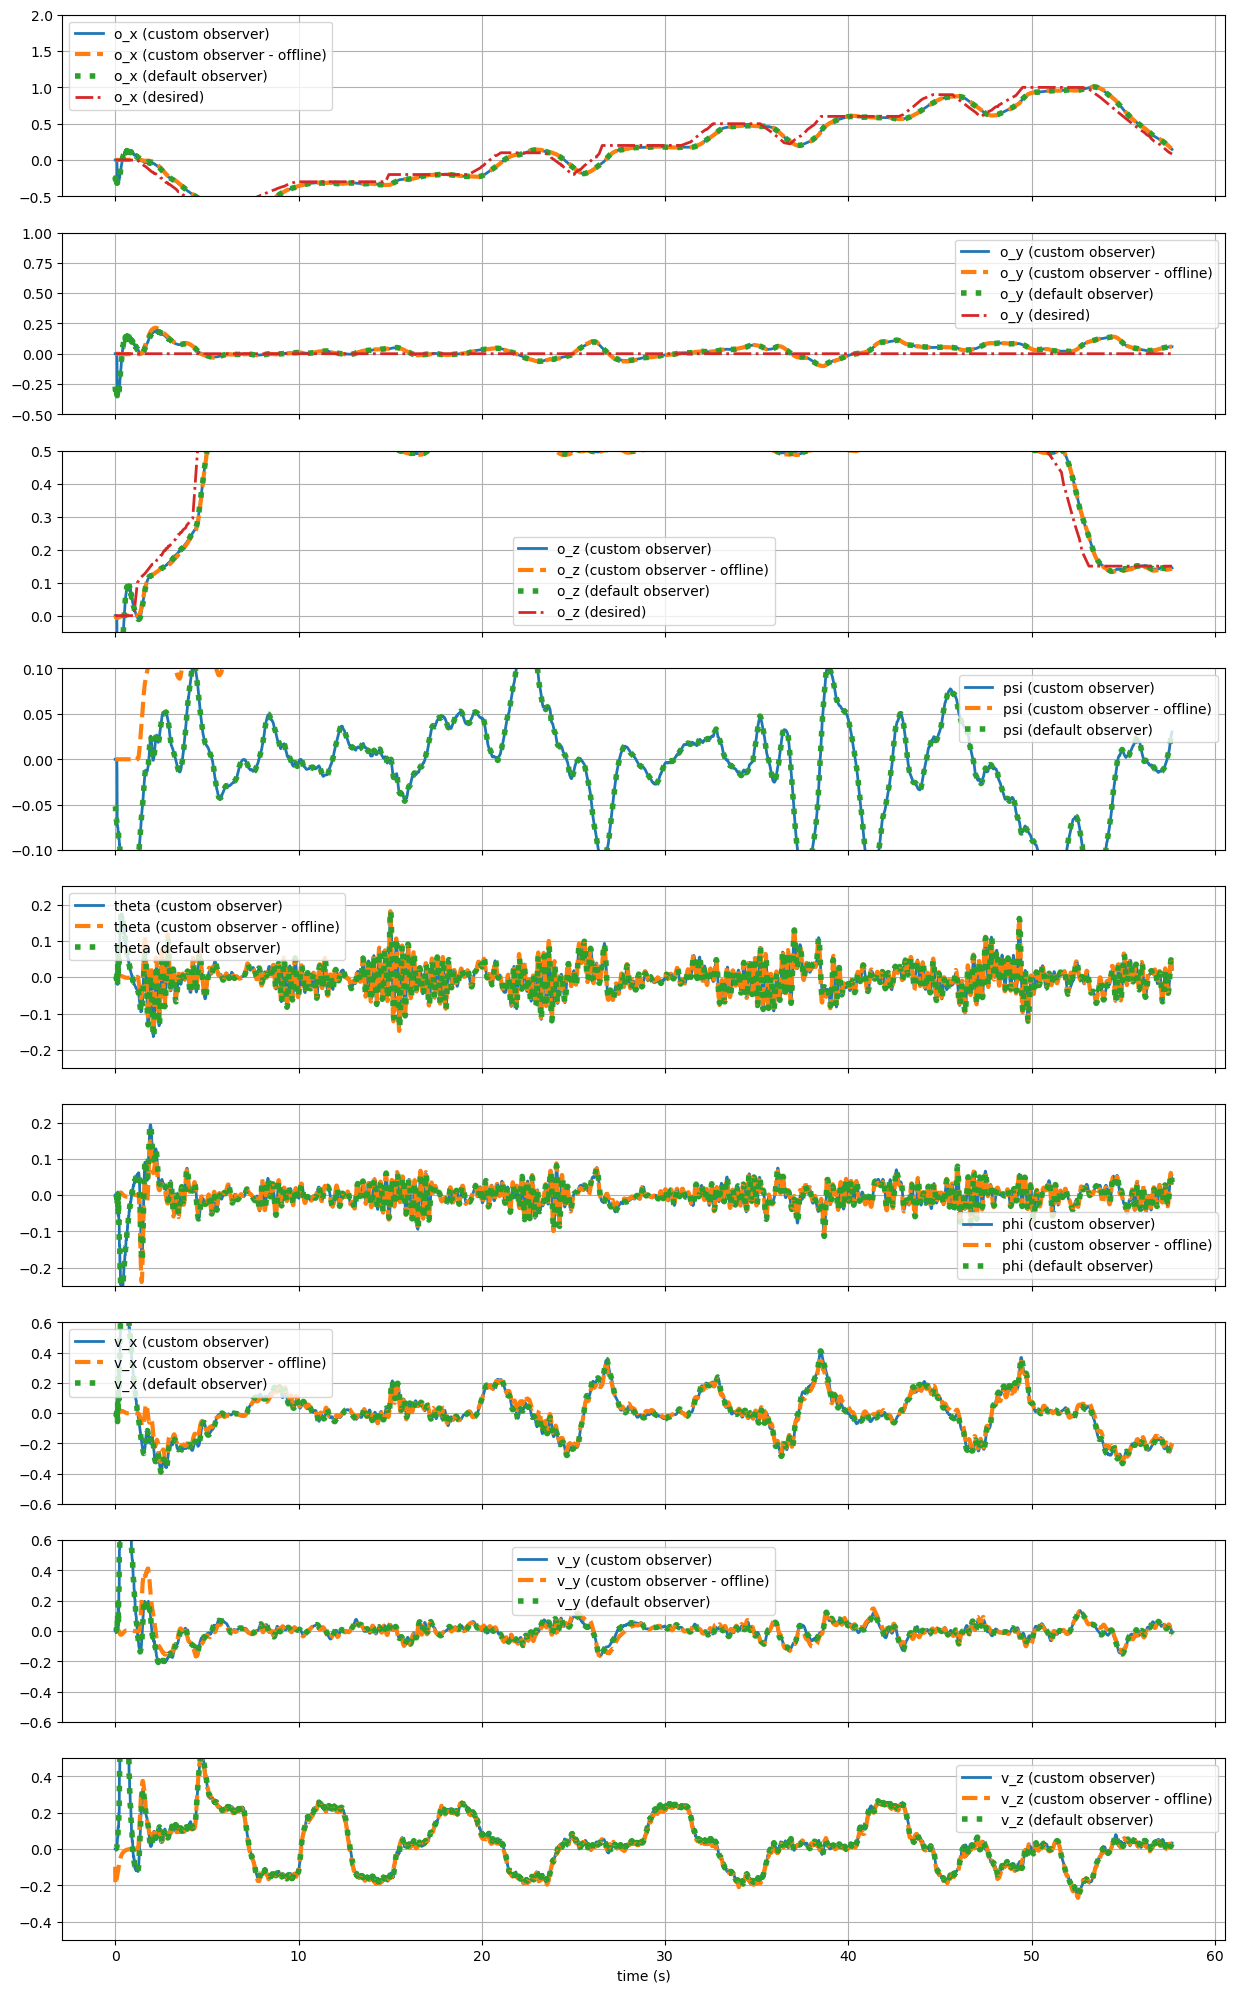

In [11]:
fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-0.5, 2])
ax_o_y.set_ylim([-0.5, 1])
ax_o_z.set_ylim([-0.05, 0.5])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.25, 0.25])
ax_phi.set_ylim([-0.25, 0.25])
ax_v_x.set_ylim([-0.6, 0.6])
ax_v_y.set_ylim([-0.6, 0.6])
ax_v_z.set_ylim([-0.5, 0.5])

plt.show()

## x-z plane

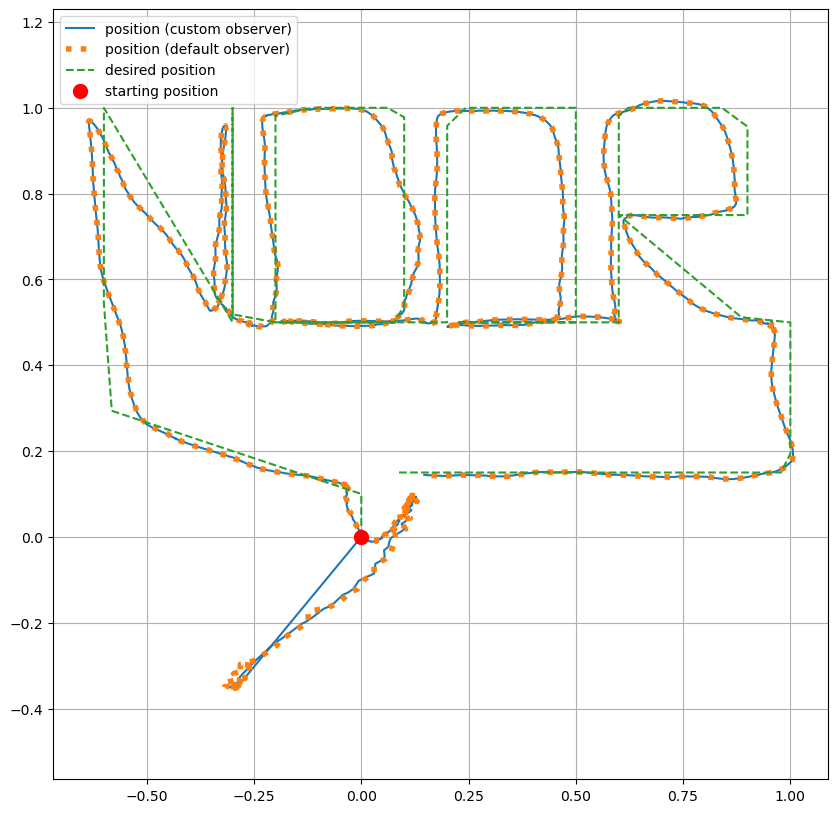

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(o_x_custom, o_z_custom, label='position (custom observer)')
plt.plot(o_x_default, o_z_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_z_des, '--', label='desired position')
plt.plot(o_x_des[0],o_y_des[0],'ro',markersize=10,label= 'starting position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

## Top Down View

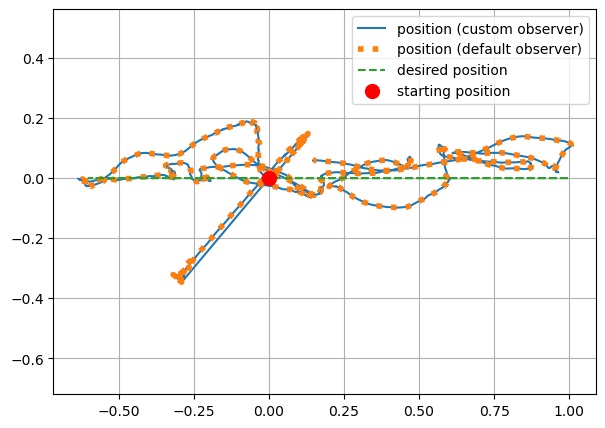

In [28]:
plt.figure(figsize=(7, 5))

plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.plot(o_x_des[0],o_y_des[0],'ro',markersize=10,label= 'starting position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Error Analysis

## Y RMSE

In [31]:
print('x RMSE = ',rmse(o_x_custom,o_x_des))
print('y RMSE = ',rmse(o_y_custom,o_y_des))
print('z RMSE = ',rmse(o_z_custom,o_z_des))
print('psi RMSE = ',rmse(psi_custom,psi_default))
print('theta RMSE = ',rmse(theta_custom,theta_default))
print('phi RMSE = ',rmse(phi_custom,phi_default))

x RMSE =  0.08337787452324942
y RMSE =  0.05824101545973434
z RMSE =  0.06820105450654203
psi RMSE =  0.0027341954630720477
theta RMSE =  0.004451717704754746
phi RMSE =  0.002809808143047817
